# Importing Packages

In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestClassifier

The below Function standardises the diffrent readings with respect to its sample rate and makes them each reading in 1 sec time frame, we are taking mean to convert them into 1 entry

In [2]:
def dataset(df,tag,):
    final_df = pd.DataFrame()
    for i in df.columns:
        W_list = df[i]
        timestamp = datetime.datetime.fromtimestamp( W_list[0]).strftime('%Y-%m-%d %H:%M:%S')
        timestamp = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        freq = W_list[1]
        W_list = W_list[2:]
        ts = list(range(len(W_list)+int(freq)))        
        for j in range(0,len(W_list),int(freq)):
            ts[j:int(j+freq)] = [timestamp]*int(freq)
            timestamp = timestamp + datetime.timedelta(seconds=1)
        ts = ts[0:len(W_list)]   
        final_df[tag + str(i)] = pd.Series(W_list)
        #print(len(final_df))
        final_df["Timestamp"] = ts
    final_df = final_df.groupby(['Timestamp']).mean()
    return final_df 

# Reading Data

Using Glob package we are walking through the folders to get the data and compile them into a list of dataframes with respect to each participants

In [3]:
finaldf = pd.DataFrame() 
dflist = []
c = 1       
for name in glob.glob(r'D:/Data Science Assignement/Stress-Predict-Dataset-main/Raw_data/*'):
    finaldflist = []
    filenames = glob.glob(name+'/*.csv')

    for csv in filenames:
        if 'tag' in csv or 'IBI' in csv or "ACC" in csv:
            continue
        else:
            df = pd.read_csv(csv,header= None)
            tag = csv.split("\\")
            tag = tag[-1].replace('.csv','')
            x =dataset(df,tag)
            finaldflist.append(x)
    finaldf_each = pd.DataFrame()
    finaldf_each['Timestamp'] = 1
    for i in finaldflist:
        finaldf_each = finaldf_each.merge(i, how = 'outer', on = 'Timestamp')
    finaldf_each = finaldf_each.dropna(axis = 0 )
    finaldf_each["Participant"] = c
    c += 1   
    dflist.append(finaldf_each)

# Adding labels and Data Cleaning

Now we add the Tag df to determine the stress level <br>
Stress = 1 = Stressful <br>
Stress = 0 = Not stressful <br>
Stress = -1 = Base reading

In [4]:
def timeconvert(a):
    return datetime.datetime.strptime(datetime.datetime.fromtimestamp(a).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')

In [5]:
file = []
for name in glob.glob(r'D:/Data Science Assignement/Stress-Predict-Dataset-main/Raw_data/*/tag*.csv'):
    df = pd.read_csv(name,header= None)
    df[0] = df[0].apply(timeconvert)
    ## correction of Tag for S10 and S30
    if "S18" in name or "S30" in name:
        df[0][0] = df[0][0] + + datetime.timedelta(hours=12)
    file.append(df)

Note there is an error in data of tags for subject 18 and 30 the first tag is 12 hours behind,

In [6]:
for i in range(len(dflist)): 
    dflist[i]['Y'] = 0
    cond0 = [dflist[i]["Timestamp"]<file[i][0][0]]
    choice0 = [-1]
    dflist[i]['Y'] = np.select(cond0,choice0,default = dflist[i]['Y'])
    for j in range(0,6):
        if j%2 == 0:
            cond = [np.logical_and(dflist[i]["Timestamp"]>file[i][0][j],dflist[i]["Timestamp"]<file[i][0][j+1])]
            choice = [1]
            dflist[i]['Y'] = np.select(cond,choice,default = dflist[i]['Y'])
        elif j == 7:
            cond2 = [dflist[i]["Timestamp"]>file[i][0][j]]
            choice2 = [2]
            dflist[i]['Y'] = np.select(cond2,choice2,default = dflist[i]['Y'])
    dflist[i] = dflist[i][dflist[i]["Y"] != 2 ]

In [7]:
dflist[10].describe()

,BVP0,EDA0,HR0,TEMP0,Participant,Y
count,3268.000000,3268.000000,3268.000000,3268.000000,3268.0,3268.000000
mean,0.000680,0.346763,89.024697,27.544002,11.0,0.170747
std,10.510241,0.159075,8.286253,0.321649,0.0,0.723205
min,-119.763281,0.139016,52.000000,26.970000,11.0,-1.000000
25%,-2.183008,0.238953,84.700000,27.270000,11.0,0.000000
50%,0.059375,0.285079,89.040000,27.510000,11.0,0.000000
75%,2.489023,0.413992,94.050000,27.890000,11.0,1.000000
max,87.644219,1.592250,112.580000,28.110000,11.0,1.000000


now we create a base reading under normal condition <br>
this is to unify the data of diffrent subjects as base reading of 1 person can very from base rerading of the other person

In [8]:
df_base = []
for i in dflist:
    basedf = i[i["Y"] == -1]
    df_base.append(basedf)
df_base[0].head()
    
df_base[17].describe()

,BVP0,EDA0,HR0,TEMP0,Participant,Y
count,669.000000,669.000000,669.000000,669.000000,669.0,669.0
mean,-0.013734,1.603236,78.243886,27.614634,18.0,-1.0
std,14.321722,0.728761,7.853514,0.801909,0.0,0.0
min,-95.053125,0.555961,58.000000,26.750000,18.0,-1.0
25%,-1.984063,0.730915,73.100000,26.830000,18.0,-1.0
50%,-0.037031,1.684932,78.450000,27.290000,18.0,-1.0
75%,1.977812,2.249728,84.950000,28.470000,18.0,-1.0
max,126.206094,2.937746,92.450000,29.090000,18.0,-1.0


In [9]:
for i in range(len(dflist)):
    dflist[i] = dflist[i][dflist[i]["Y"] != -1]

In [10]:
dflist[10].describe()

,BVP0,EDA0,HR0,TEMP0,Participant,Y
count,2645.000000,2645.000000,2645.000000,2645.000000,2645.0,2645.000000
mean,-0.000178,0.377488,90.103626,27.458771,11.0,0.446503
std,10.368740,0.161945,7.701651,0.277576,0.0,0.497224
min,-119.763281,0.196673,71.050000,26.970000,11.0,0.000000
25%,-2.169219,0.265860,84.970000,27.230000,11.0,0.000000
50%,0.076406,0.299173,89.720000,27.450000,11.0,0.000000
75%,2.456250,0.481058,95.020000,27.610000,11.0,1.000000
max,68.191406,1.592250,112.580000,28.050000,11.0,1.000000


Now lets plot the time- graphs for first data subject

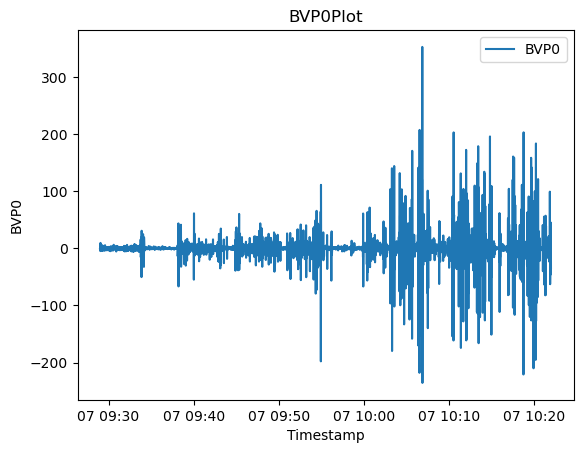

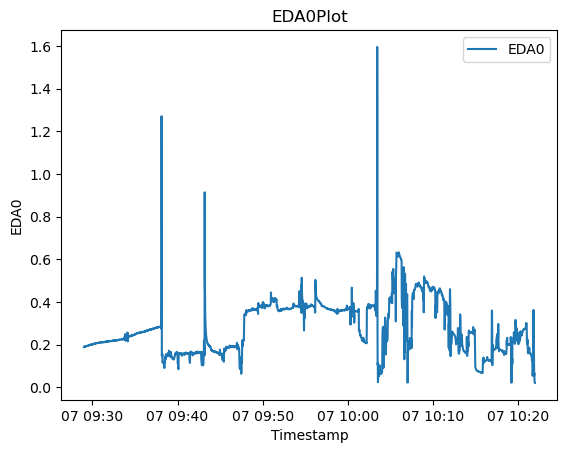

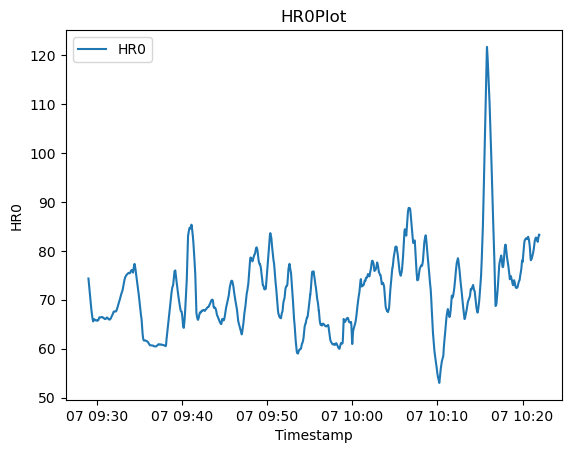

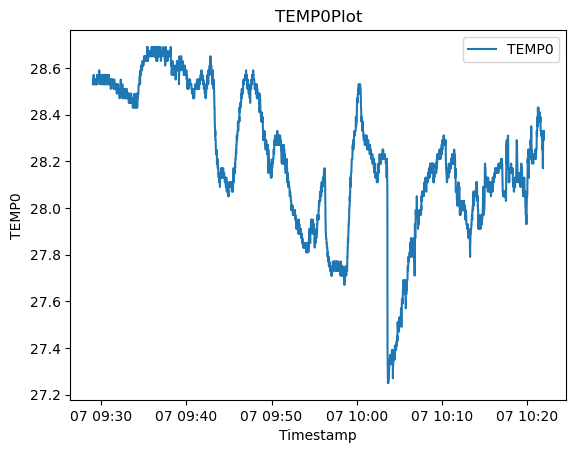

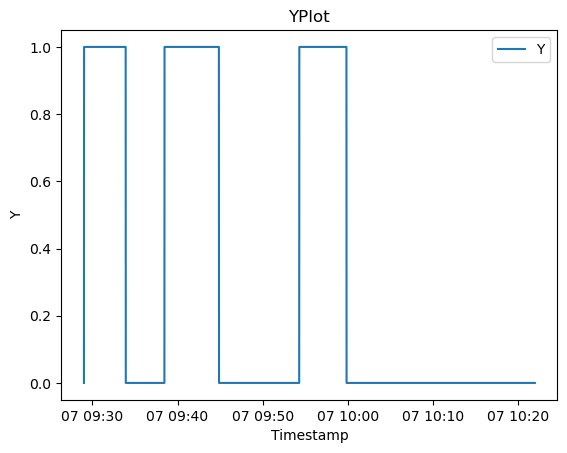

In [11]:
for i in range(1):    
    for j in dflist[i].columns: 
        if j == "Timestamp" or j == "Participant":
            continue
        # plot the data
        plt.plot(dflist[i]["Timestamp"],dflist[i][j], label=j)
        # add titles, labels, and legend
        plt.title(j+"Plot")
        plt.xlabel('Timestamp')
        plt.ylabel(j)
        plt.legend()
        # show the plot
        plt.show()

In [12]:
dflist[0].head()

,Timestamp,BVP0,EDA0,HR0,TEMP0,Participant,Y
79,2022-02-07 09:29:00,-1.643750,0.188985,74.35,28.53,1,0
80,2022-02-07 09:29:01,-2.287031,0.190266,74.03,28.53,1,1
81,2022-02-07 09:29:02,-4.832344,0.189946,73.75,28.55,1,1
82,2022-02-07 09:29:03,9.459375,0.190907,73.48,28.55,1,1
83,2022-02-07 09:29:04,0.353125,0.190587,73.22,28.53,1,1


# Modeling

we check for autocorrelation between observations
    

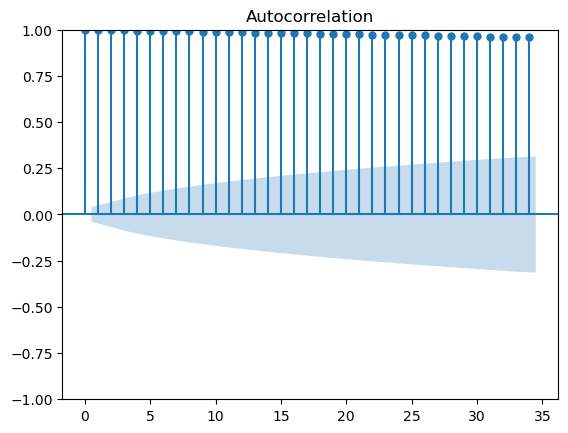

Timestamp


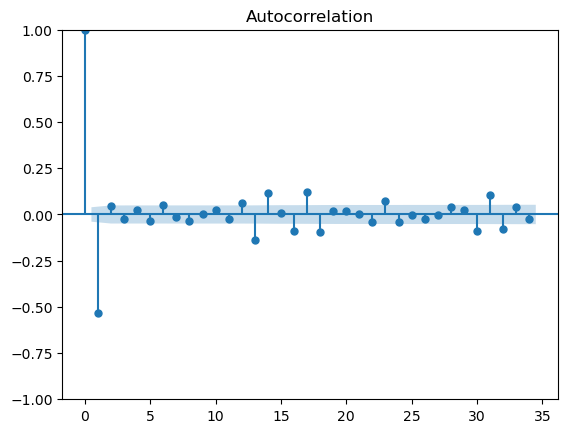

BVP0


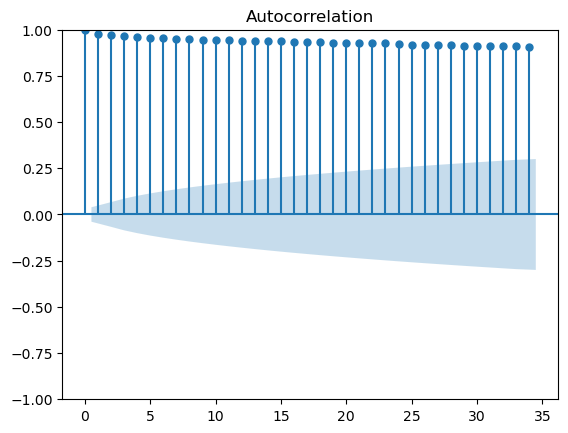

EDA0


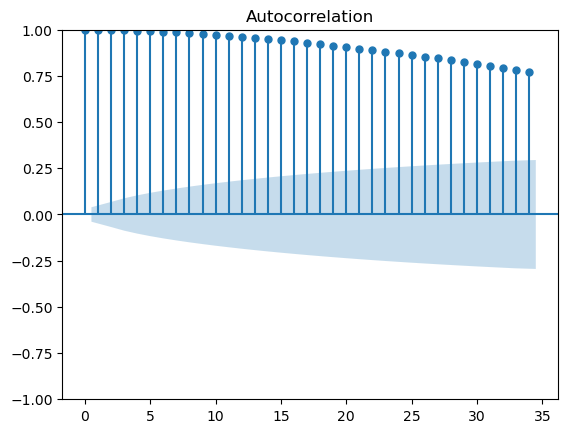

HR0


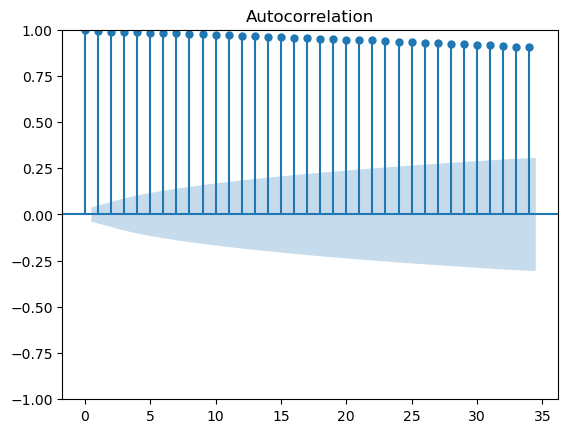

TEMP0


C:\Users\Akshay D Nair\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


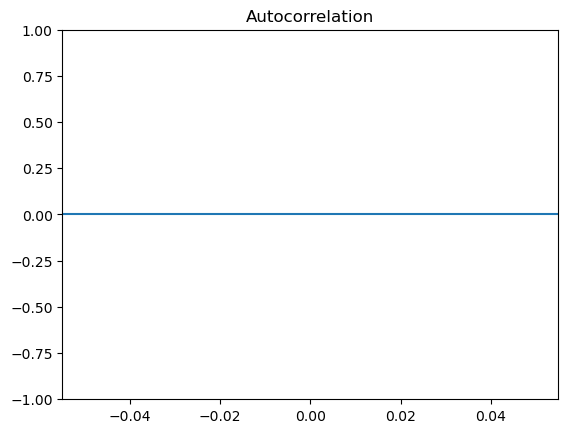

Participant


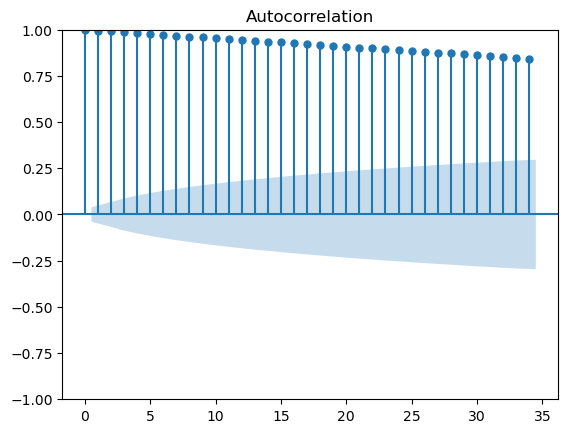

Y


In [19]:
# Plot ACF
for i in dflist[7].columns:   
    plot_acf(dflist[7][i])
    plt.show()
    print(i)

In [14]:
import time
def epochconvert(a):
    a = time.strptime(a, '%Y-%m-%d %H:%M:%S')
    u = int(time.mktime(a))
    return u
for i in range(len(dflist)):
    dflist[i]['Timestamp'] = dflist[i]['Timestamp'].astype(str).apply(epochconvert)

first we devide the data in train and test. For our case we are splitting the data in 60-40 train-test split. As the data we have here is a time series we are gonna split sequencially and not random. then we are applying random forest calassifier

In [20]:
dfreport =[]
dfcm = []
dfacc = []
for df in dflist:
    X = df.drop(['Participant','Y','Timestamp',"BVP0"], axis=1)
    y = df["Y"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,shuffle=False)

    rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # Fit the model on the training data
    rfc.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = rfc.predict(X_test)

    # Generate a classification report
    report = classification_report(y_test, y_pred)
    dfreport.append(report)
    cm = confusion_matrix(y_test, y_pred)
    dfcm.append(cm)
    acc = accuracy_score(y_test, y_pred)
    dfacc.append(acc)

C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akshay D Nair\anaconda3\lib\site-packages\skle

In [21]:
print(dfacc)

[0.7790880503144654, 0.47198641765704585, 0.13430127041742287, 0.9621848739495799, 0.1344860710854947, 0.4175824175824176, 0.5786948176583493, 0.8215353938185443, 0.21197252208047104, 0.7929292929292929, 0.8780718336483931, 0.8245778611632271, 0.8876508820798514, 0.07739130434782608, 0.4384976525821596, 0.7011278195488722, 0.9125230202578268, 0.5861440291704649, 0.5048262548262549, 0.6271649954421149, 0.7947725072604066, 0.8201798201798202, 0.267, 0.8996101364522417, 0.7755298651252408, 0.10402999062792877, 0.8904235727440147, 0.49162011173184356, 0.7514018691588785, 0.5406427221172023, 0.6794625719769674, 0.4189837008628955, 0.3375363724539282, 0.39627906976744187, 0.10110450297366186]
